In [1]:
#Packages installation
# !pip install xgboost
# !pip install category_encoders
# !pip install shap

In [2]:
#Libraries import
import pandas as pd
import math
import xgboost
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import matplotlib
import shap

c:\karol\python\venvXGB\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Input parameters
test_size_value = 0.25
random_state = 1234

#Internal parameters
symbol_missing='Missing'
target_name = 'default12'
time_name = 'period'
intercept_name = 'Intercept'
id_vars = ['aid']
event_value = 'outstanding_bad'
all_value = 'outstanding'

In [4]:
#Data import
# ef = pd.ExcelFile('abt_app.xls')
# df = ef.parse('Sheet1')
# df[intercept_name] = 1

In [5]:
df = pd.read_sas('abt_app.sas7bdat', encoding='LATIN2')

In [6]:
print(type(df['app_char_job_code'][0]))
print(df['app_char_job_code'][0])

<class 'str'>
Permanent


In [7]:
# df=df[('197501'<=df['period']) & (df['period']<='198712') & (df['product']=='css') & (df['decision']=='A')]

In [8]:
df[intercept_name]=1
df[event_value]=df['app_loan_amount']*df[target_name]
df[all_value]=df['app_loan_amount']
df.head()

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,cid,aid,product,period,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,...,default12,default_cross3,default_cross6,default_cross9,default_cross12,cross_app_loan_amount,cross_app_n_installments,Intercept,outstanding_bad,outstanding
0,0000001330,css1975010100098,css,197501,45.0,0.326905,1.530456,3267.0,5000.0,24.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,5000.0,5000.0
1,0000002179,css1975010100120,css,197501,42.0,0.538908,2.903600,1722.0,5000.0,24.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,5000.0
2,0000000146,css1975010200014,css,197501,59.0,0.543742,3.364738,1486.0,5000.0,24.0,...,0.0,0.0,0.0,0.0,0.0,5000.0,24.0,1,0.0,5000.0
3,0000000479,css1975010200047,css,197501,63.0,0.587702,3.236246,1545.0,5000.0,24.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,5000.0
4,0000004514,css1975010200151,css,197501,48.0,0.436407,1.506932,3318.0,5000.0,24.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,5000.0,5000.0


In [9]:
#List of variables
# vars = [var for var in list(df) if var[0:3].lower() in ['app','act']]
vars = [var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']]

#Splitting into numeric and character variables
varsc = list(df[vars].select_dtypes(include='object'))
varsn = list(df[vars].select_dtypes(include='number'))

In [10]:
#How many mising values do we have in target variable?
df[target_name].isna().sum() 

1576

In [11]:
#Dropping mising values in target variable
df.dropna(subset=[target_name], inplace=True)

In [12]:
#Categorical variables coding
enc = ce.BinaryEncoder(cols=varsc)
df_ce = enc.fit_transform(df[varsc])
varsc_ce = list(df_ce)

# df_ce = enc.fit_transform(df)
df_ce=df

vars_target_id_ce = varsn + [target_name] + [time_name] + [intercept_name] + [event_value] + [all_value] + id_vars
vars_ce = varsn
# vars_target_id_ce = varsn + varsc_ce + [target_name] + [time_name] + [intercept_name] + [event_value] + [all_value] + id_vars
# vars_ce = varsn + varsc_ce

In [13]:
df_ce=df_ce[('197501'<=df_ce['period']) & (df_ce['period']<='198712') & (df_ce['product']=='css') & (df_ce['decision']=='A')]

In [14]:
#Splitting for train and test datasets
train, test = train_test_split(df_ce[vars_target_id_ce], random_state = 1234, test_size=0.4)
print(train.shape, test.shape)

(5916, 200) (3945, 200)


In [15]:
#Input data
X = train[vars_ce]
Y = train[target_name]

X_test = test[vars_ce]
Y_test = test[target_name]

XGBoost algorithm can be adjusted using different hyperparameters. Main are:
- learning rate - [0, 1], default=0.3 - step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative;
- max_depth - [0,∞], default=6 - maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value;
- max_delta_step - [0,∞], default=0 - maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update;
- reg_lambda - default=1 - L2 regularization term on weights. Increasing this value will make model more conservative;
- reg_alpha - default=0 - L1 regularization term on weights. Increasing this value will make model more conservative;
- max_leaves - int, default=0 - maximum number of nodes to be added. Not used by exact tree method.
    
Full hyperparameters list can be found here: https://xgboost.readthedocs.io/en/stable/parameter.html

In [16]:
#Transforming into dedicated structures
xdm_train = xgboost.DMatrix(X, Y, enable_categorical=True, missing=True)
xdm_test  = xgboost.DMatrix(X_test, Y_test, enable_categorical=True, missing=True)

#Model training
model = xgboost.train({'max_depth': 5, "seed": 123, 'objective': 'binary:logitraw','learning_rate': 0.2,
                     'min_split_loss': 3, 'eval_metric': 'auc'}, xdm_train, 20, [(xdm_test, 'eval'), (xdm_train, 'train')])
print(model)

[0]	eval-auc:0.82183	train-auc:0.83633
[1]	eval-auc:0.82720	train-auc:0.84593
[2]	eval-auc:0.83557	train-auc:0.85399
[3]	eval-auc:0.84204	train-auc:0.86114
[4]	eval-auc:0.84467	train-auc:0.86711


Pass `evals` as keyword args.


[5]	eval-auc:0.84639	train-auc:0.87128
[6]	eval-auc:0.84814	train-auc:0.87544
[7]	eval-auc:0.84938	train-auc:0.87989
[8]	eval-auc:0.85082	train-auc:0.88294
[9]	eval-auc:0.85325	train-auc:0.88734
[10]	eval-auc:0.85436	train-auc:0.89011
[11]	eval-auc:0.85513	train-auc:0.89206
[12]	eval-auc:0.85636	train-auc:0.89495
[13]	eval-auc:0.85761	train-auc:0.89760
[14]	eval-auc:0.85776	train-auc:0.90146
[15]	eval-auc:0.86037	train-auc:0.90590
[16]	eval-auc:0.86097	train-auc:0.90791
[17]	eval-auc:0.86137	train-auc:0.91078
[18]	eval-auc:0.86137	train-auc:0.91251
[19]	eval-auc:0.86191	train-auc:0.91428


In [17]:
# Prediction calculation
Y_pred_train = model.predict(xdm_train)
Y_pred_test = model.predict(xdm_test)

GINI TRAIN =  82.856%
GINI TEST =  72.382%


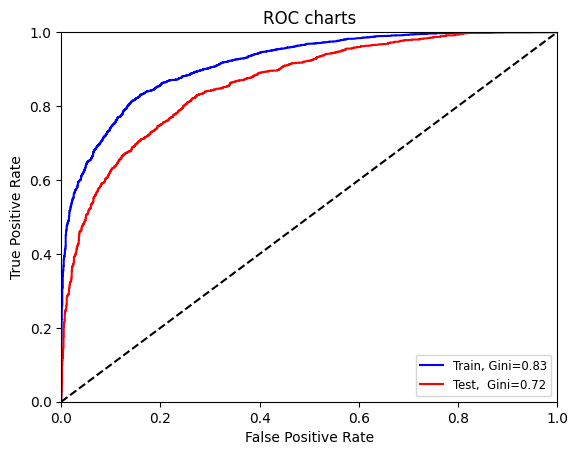

In [18]:
#Predictive power calculation
gini_train = 2 * roc_auc_score(Y,Y_pred_train)-1
print('GINI TRAIN = ', '{:.3%}'.format(gini_train))
gini_test  = 2 * roc_auc_score(Y_test,Y_pred_test)-1
print('GINI TEST = ', '{:.3%}'.format(gini_test))

fpr_train, tpr_train, thresholds_train = roc_curve(Y.values.ravel(), Y_pred_train)
fpr_test,  tpr_test,  thresholds_test  = roc_curve(Y_test.values.ravel(),  Y_pred_test)
fig = plt.figure()
plt.plot(fpr_train, tpr_train, 'blue', label='Train, Gini='+'{:4.2f}'.format(gini_train))
plt.plot(fpr_test,  tpr_test,  'red', label='Test,  Gini='+'{:4.2f}'.format(gini_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC charts')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

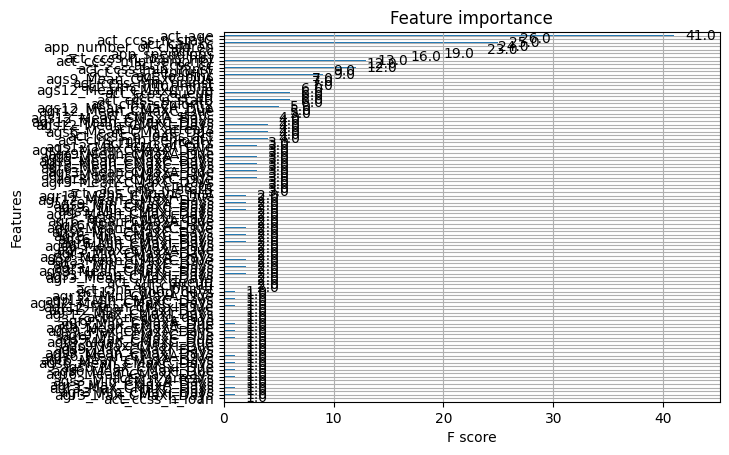

In [19]:
#Classical Tree variable importance
xgboost.plot_importance(model)

In [20]:
#Saving the model
model.save_model('xgb1.model')
# model.dump_model('C:/Users/karol/Desktop/CS_SGH/ML/xgb1.dump')

In [21]:
#Reading the model
model2 = xgboost.Booster() 
model2.load_model('xgb1.model')
Y_pred_test2 = model2.predict(xdm_test)

In [22]:
#Shapley reporting XAI
model_explainer = shap.TreeExplainer(model, X)
shaps_train=model_explainer(X)

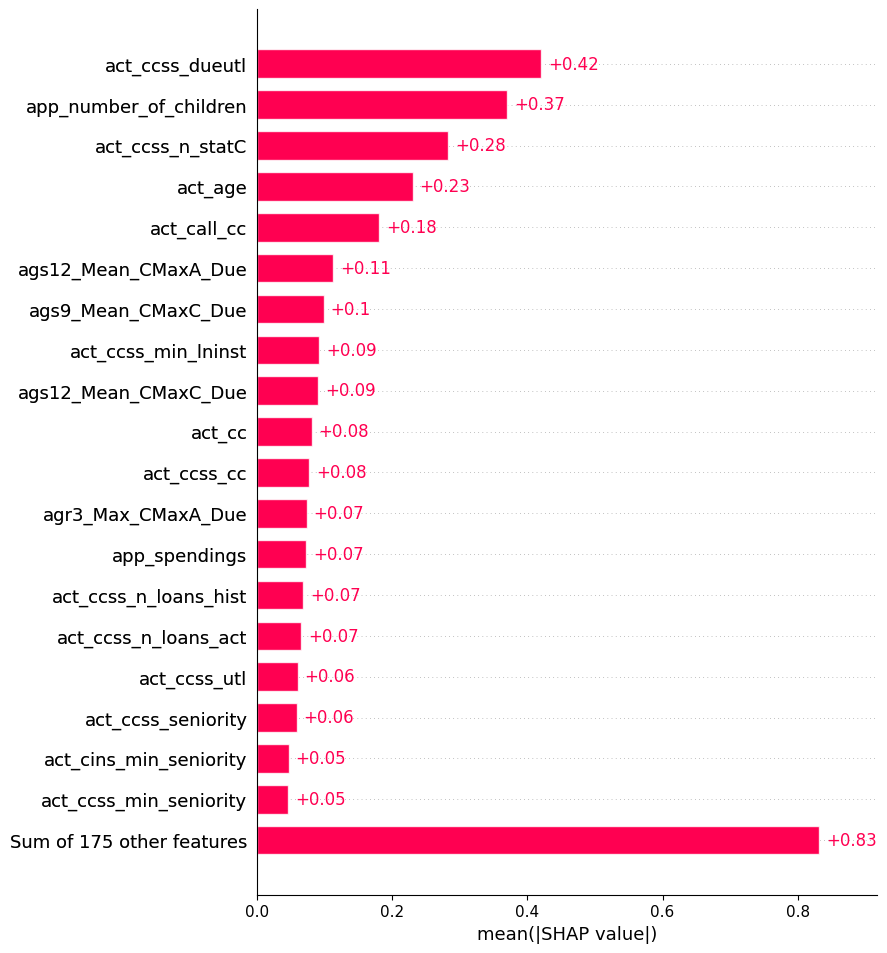

In [23]:
shap.plots.bar(shaps_train,max_display=20)

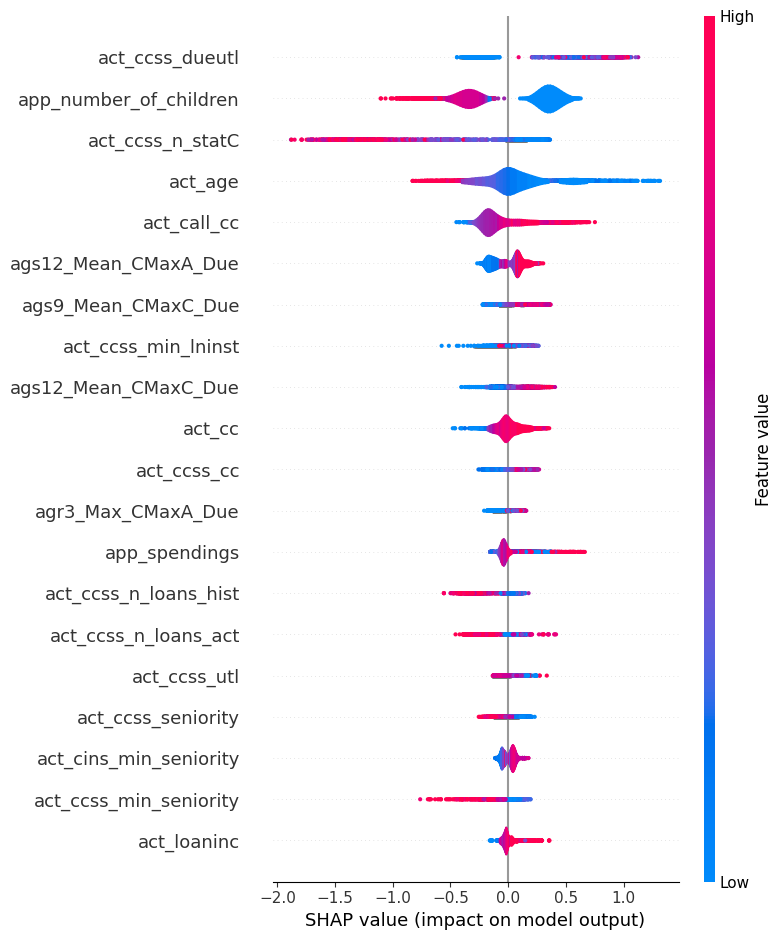

In [24]:
shap.summary_plot(shaps_train,X,plot_type='violin')

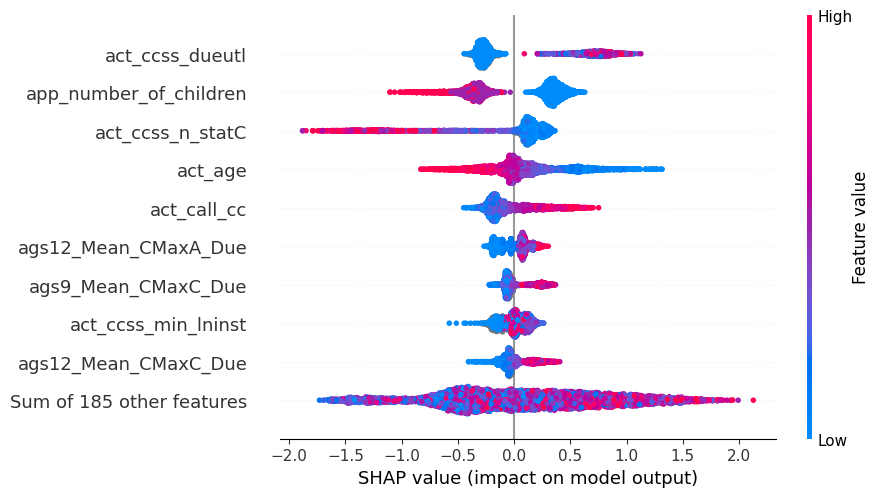

In [25]:
shap.plots.beeswarm(shaps_train)

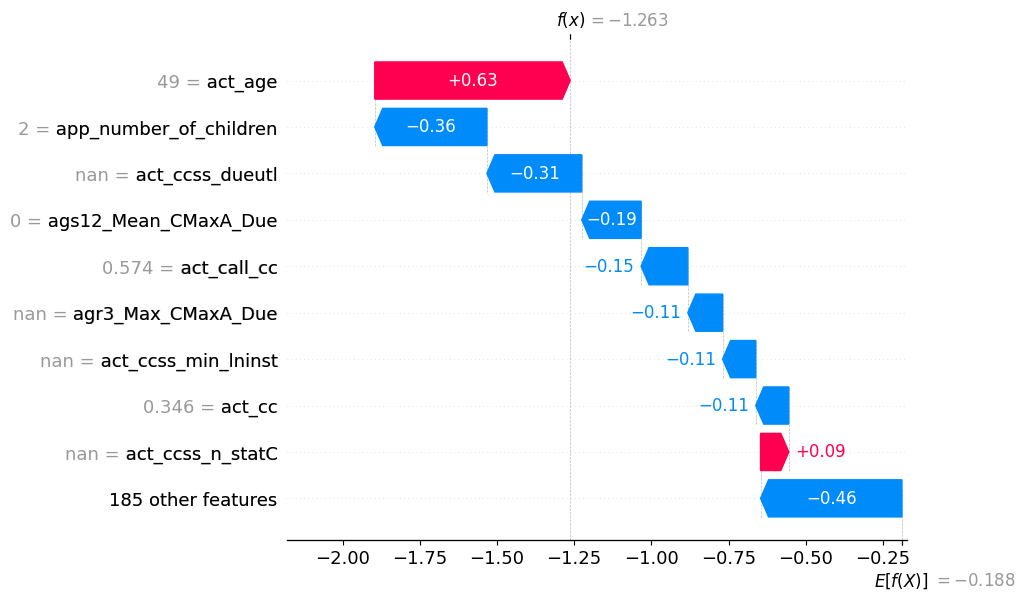

In [26]:
shap.waterfall_plot(shaps_train[0])

In [27]:
shap.initjs()
shap.plots.force(shaps_train[0])

In [28]:
# Python scoring code
def call_model():
    print("Start")
    import xgboost
    import pandas as pd
    import math
    import category_encoders as ce

    target_name='default12'
    time_name='period'
    intercept_name='Intercept'
    event_value='outstanding_bad'
    all_value='outstanding'
    id_vars=['aid']    

    df = pd.read_sas("abt_tmp.sas7bdat", encoding='LATIN2')

    #List of variables
    #     vars = [var for var in list(df) if var[0:3].lower() in ['app','act']]
    vars = [var for var in list(df) if var[0:3].lower() in ['app','act','agr','ags']]

    #Splitting into numeric and character variables
    varsc = list(df[vars].select_dtypes(include='object'))
    varsn = list(df[vars].select_dtypes(include='number'))


    #Categorical variables coding
    enc = ce.BinaryEncoder(cols=varsc)
    df_ce = enc.fit_transform(df[varsc])
    varsc_ce = list(df_ce)

    #     df_ce = enc.fit_transform(df)
    df_ce=df

    vars_ce = varsn
    #     vars_ce = varsn + varsc_ce

    test = df_ce
    test[target_name]=1

    X_test=test[vars_ce]
    Y_test=test[target_name]


    xdm_test  = xgboost.DMatrix(X_test, Y_test, enable_categorical=True, missing=True)


    model = xgboost.Booster()

    model.load_model("xgb1.model")

    Y_pred_test = model.predict(xdm_test)

    df_out=df

    df_out['SCORECARD_POINTS']= pd.DataFrame(Y_pred_test)

    fin_vars= ['SCORECARD_POINTS'] + [time_name] + id_vars

    df_out=df_out[fin_vars]

    df_out.to_csv("outscore.csv", index=False)

    print("End")
    return
call_model()


Start
End
